# Introduction

For the purpose of early detetcion of Alzheimer's, we train selected classifier models on the training dataset using a sub-dataset of patients exhibiting memory complaints, and then compare their performance on the validation set. We also use hyperparamater tuning to get the best F1 score. We care about F1 scores because false negatives are critical.

In [3]:
## For data handling
import pandas as pd
import numpy as np

## For plotting
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import set_style

# Set plot style
set_style("whitegrid")

## For preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer

## For splitting data
from sklearn.model_selection import train_test_split

## For evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

## For building pipelines
from sklearn.pipeline import Pipeline

## Classification Models Explored
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

## Loading the data

In [5]:
## Reading the traning and testing datasets
df_train = pd.read_csv("../../data/train_set.csv")
df_test = pd.read_csv("../../data/validation_set.csv")

## Dropping redundant columns
df_train = df_train.drop(columns = ['DoctorInCharge' , 'PatientID'])
df_test = df_test.drop(columns = ['DoctorInCharge' , 'PatientID'])

## Restricting to patients with NoMemoryComplaints
df_train = df_train.loc[df_train.MemoryComplaints == 0]
df_test = df_test.loc[df_test.MemoryComplaints == 0]

df_train.head()

,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,...,FunctionalAssessment,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis
2,81,0,1,0,22.923111,0,9.314832,8.917378,3.807813,9.241849,...,4.594907,0,1,8.681801,0,0,0,0,0,1
3,90,0,1,3,31.430904,0,0.996496,7.108725,5.328610,4.977538,...,0.880355,0,0,7.805410,0,0,0,0,0,0
4,89,0,1,3,39.570099,0,1.576700,5.712014,1.026138,4.670244,...,0.293490,0,0,1.307295,0,0,0,0,1,1
5,62,1,0,1,27.249527,0,19.329277,5.964852,0.276126,8.694453,...,3.517218,0,1,8.152459,0,0,0,0,0,1
6,84,0,0,2,34.164347,0,14.236514,5.584057,7.155148,9.214991,...,9.494738,0,0,9.145943,0,1,0,0,1,0


In [7]:
## Seperating features into subcategories

all_features = ['Age', 'Gender', 'Ethnicity', 'EducationLevel', 'BMI',
               'Smoking', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality',
               'SleepQuality', 'FamilyHistoryAlzheimers', 'CardiovascularDisease',
               'Diabetes', 'Depression', 'HeadInjury', 'Hypertension', 'SystolicBP',
               'DiastolicBP', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL',
               'CholesterolTriglycerides', 'MMSE', 'FunctionalAssessment',
               'MemoryComplaints', 'BehavioralProblems', 'ADL', 'Confusion',
               'Disorientation', 'PersonalityChanges', 'DifficultyCompletingTasks',
               'Forgetfulness' , 'Diagnosis']
demo_features = ['Age', 'Gender', 'Ethnicity','EducationLevel','Diagnosis']
life_style_features = ['BMI','Smoking', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality', 'SleepQuality','Diagnosis']
medic_hist_features = ['FamilyHistoryAlzheimers', 'CardiovascularDisease','Diabetes', 'Depression', 'HeadInjury', 'Hypertension','Diagnosis']
clinical_features = ['SystolicBP','DiastolicBP', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL','CholesterolTriglycerides','Diagnosis']
cognitive_features = ['MMSE', 'FunctionalAssessment','MemoryComplaints', 'BehavioralProblems', 'ADL','Diagnosis']
symptoms_features = ['Confusion','Disorientation', 'PersonalityChanges', 'DifficultyCompletingTasks','Forgetfulness','Diagnosis']

no_cognitive = [item for item in all_features if item not in cognitive_features]
no_cognitive.append('Diagnosis')

subcategory_dict = {'all_features' : all_features,'demo':demo_features ,'lifestyle': life_style_features , 'medic' : medic_hist_features , 
                    'clinical':clinical_features , 'cognitive': cognitive_features , 'symptoms': symptoms_features , 'no_cognitive': no_cognitive}

# Logistic Regression

,all_features,demo,lifestyle,medic,clinical,cognitive,symptoms,no_cognitive
Accuracy,0.879562,0.715328,0.715328,0.715328,0.715328,0.857664,0.715328,0.715328
Precision,0.826087,0.000000,0.000000,0.000000,0.000000,0.809524,0.000000,0.000000
Recall,0.730769,0.000000,0.000000,0.000000,0.000000,0.653846,0.000000,0.000000
F1 Score,0.775510,0.000000,0.000000,0.000000,0.000000,0.723404,0.000000,0.000000


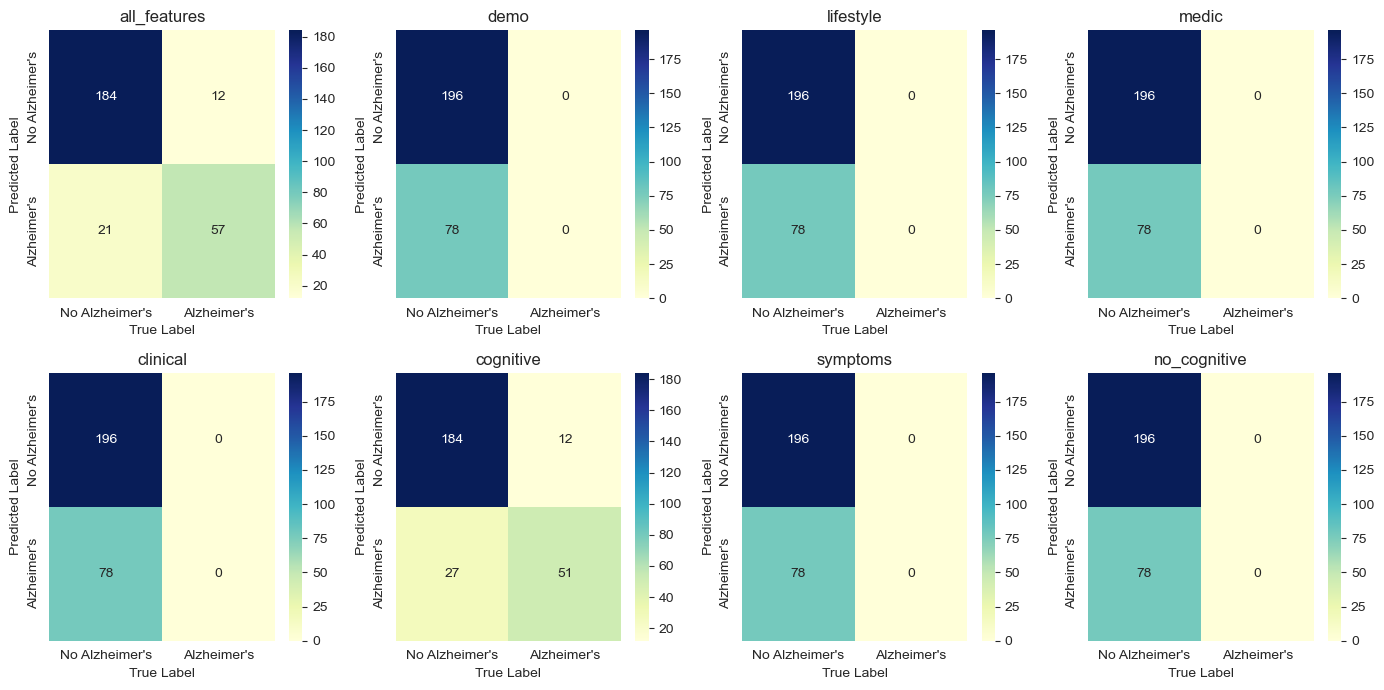

In [9]:
# Pipeline
logreg_pipe = Pipeline([
    ('scale', StandardScaler()), 
    ('logreg', LogisticRegression(max_iter=1000))
])

# Store metrics and confusion matrices
logreg_metrics = {}
logreg_conf_matrix = {}

# Run classifier across feature subcategories
for key, features in subcategory_dict.items():
    logreg_pipe.fit(df_train[features[:-1]], df_train.Diagnosis)
    pred = logreg_pipe.predict(df_test[features[:-1]])

    # Store metrics
    logreg_metrics[key] = [
        accuracy_score(df_test.Diagnosis, pred),
        precision_score(df_test.Diagnosis, pred, zero_division=0),
        recall_score(df_test.Diagnosis, pred, zero_division=0),
        f1_score(df_test.Diagnosis, pred, zero_division=0)
    ]

    # Store confusion matrix
    logreg_conf_matrix[key] = confusion_matrix(df_test.Diagnosis, pred)

# Display metrics in a dataframe
logreg_metrics_df = pd.DataFrame(logreg_metrics, index=['Accuracy', 'Precision', 'Recall', 'F1 Score'])
display(logreg_metrics_df)

# Plot confusion matrices
fig, axes = plt.subplots(2, 4, figsize=(14, 7))
axes = axes.flatten()

for idx, (key, cm) in enumerate(logreg_conf_matrix.items()):
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", ax=axes[idx],
                xticklabels=["No Alzheimer's", "Alzheimer's"],
                yticklabels=["No Alzheimer's", "Alzheimer's"])
    axes[idx].set_title(key)
    axes[idx].set_xlabel("True Label")
    axes[idx].set_ylabel("Predicted Label")

for i in range(len(logreg_conf_matrix), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# K-Nearest Neighbors (KNN)

We use GridSearchCV to find the best n_neighbors that optimizes our F1 score.

,all_features,demo,lifestyle,medic,clinical,cognitive,symptoms,no_cognitive
Accuracy,0.748175,0.653285,0.627737,0.510949,0.645985,0.937956,0.456204,0.631387
Precision,0.604651,0.326531,0.269231,0.291045,0.327273,0.906667,0.287425,0.274510
Recall,0.333333,0.205128,0.179487,0.500000,0.230769,0.871795,0.615385,0.179487
F1 Score,0.429752,0.251969,0.215385,0.367925,0.270677,0.888889,0.391837,0.217054
Best n_neighbors,5.000000,3.000000,3.000000,3.000000,3.000000,15.000000,3.000000,3.000000


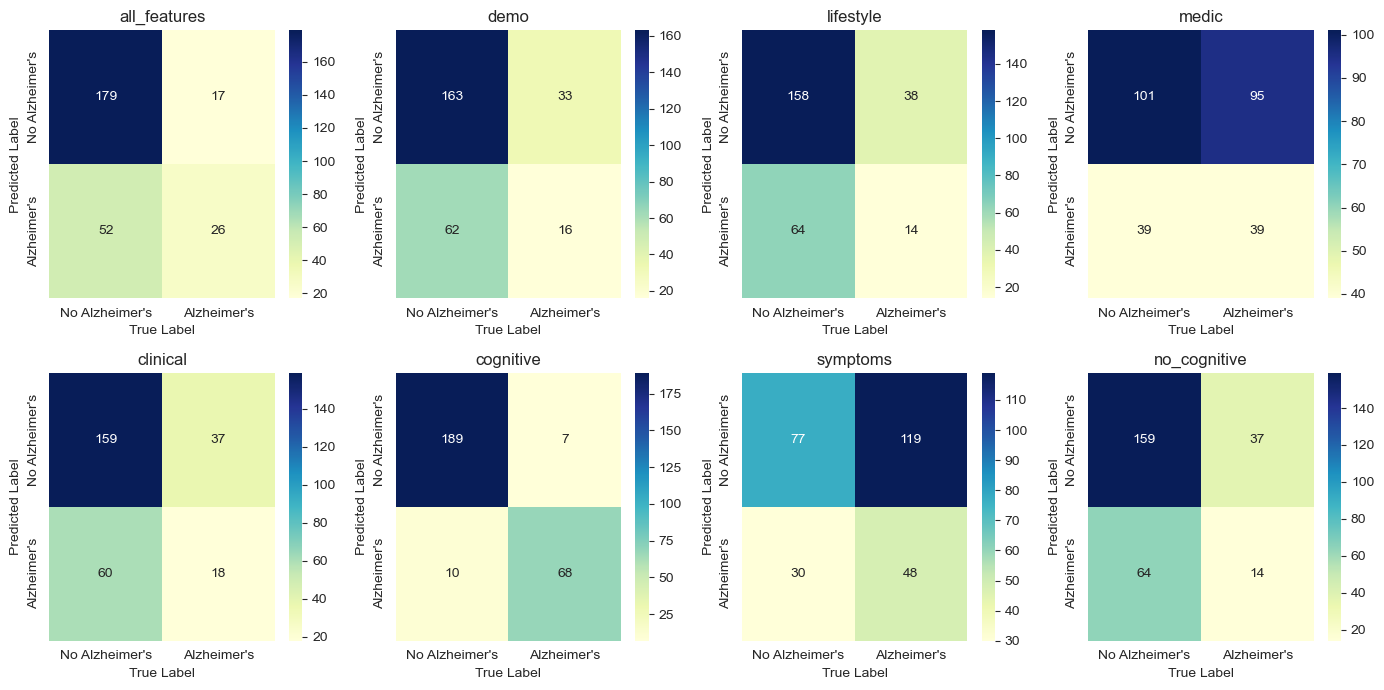

In [11]:
# Define hyperparameter grid
param_grid = {
    'knn__n_neighbors': [3, 5, 7, 10, 15]
}

# Store metrics and confusion matrices
knn_metrics = {}
knn_conf_matrix = {}

# Run classifier across feature subcategories
for key, features in subcategory_dict.items():
    # Define pipeline
    knn_pipe = Pipeline([
        ('scale', StandardScaler()),
        ('knn', KNeighborsClassifier())
    ])

    # GridSearchCV
    grid = GridSearchCV(knn_pipe, param_grid, cv=3, scoring='f1', n_jobs=-1)
    grid.fit(df_train[features[:-1]], df_train.Diagnosis)
    best_model = grid.best_estimator_
    best_params = grid.best_params_

    # Predict
    pred = best_model.predict(df_test[features[:-1]])

    # Store metrics
    knn_metrics[key] = [
        accuracy_score(df_test.Diagnosis, pred),
        precision_score(df_test.Diagnosis, pred, zero_division=0),
        recall_score(df_test.Diagnosis, pred, zero_division=0),
        f1_score(df_test.Diagnosis, pred, zero_division=0),
        best_params['knn__n_neighbors']
    ]

    # Store confusion matrix
    knn_conf_matrix[key] = confusion_matrix(df_test.Diagnosis, pred)

# Display metrics in a dataframe
knn_metrics_df = pd.DataFrame(
    knn_metrics,
    index=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Best n_neighbors']
)
display(knn_metrics_df)

# Plot confusion matrices
fig, axes = plt.subplots(2, 4, figsize=(14, 7))
axes = axes.flatten()

for idx, (key, cm) in enumerate(knn_conf_matrix.items()):
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", ax=axes[idx],
                xticklabels=["No Alzheimer's", "Alzheimer's"],
                yticklabels=["No Alzheimer's", "Alzheimer's"])
    axes[idx].set_title(f"{key}")
    axes[idx].set_xlabel("True Label")
    axes[idx].set_ylabel("Predicted Label")

for i in range(len(knn_conf_matrix), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# Decision Trees

We’ll tune the max_depth parameter using GridSearchCV.

,all_features,demo,lifestyle,medic,clinical,cognitive,symptoms,no_cognitive
Accuracy,0.937956,0.656934,0.576642,0.708029,0.598540,0.948905,0.715328,0.605839
Precision,0.929577,0.346154,0.262500,0.250000,0.309524,0.944444,0.000000,0.272727
Recall,0.846154,0.230769,0.269231,0.012821,0.333333,0.871795,0.000000,0.230769
F1 Score,0.885906,0.276923,0.265823,0.024390,0.320988,0.906667,0.000000,0.250000
Best Max Depth,5.000000,12.000000,NaN,8.000000,NaN,5.000000,3.000000,NaN


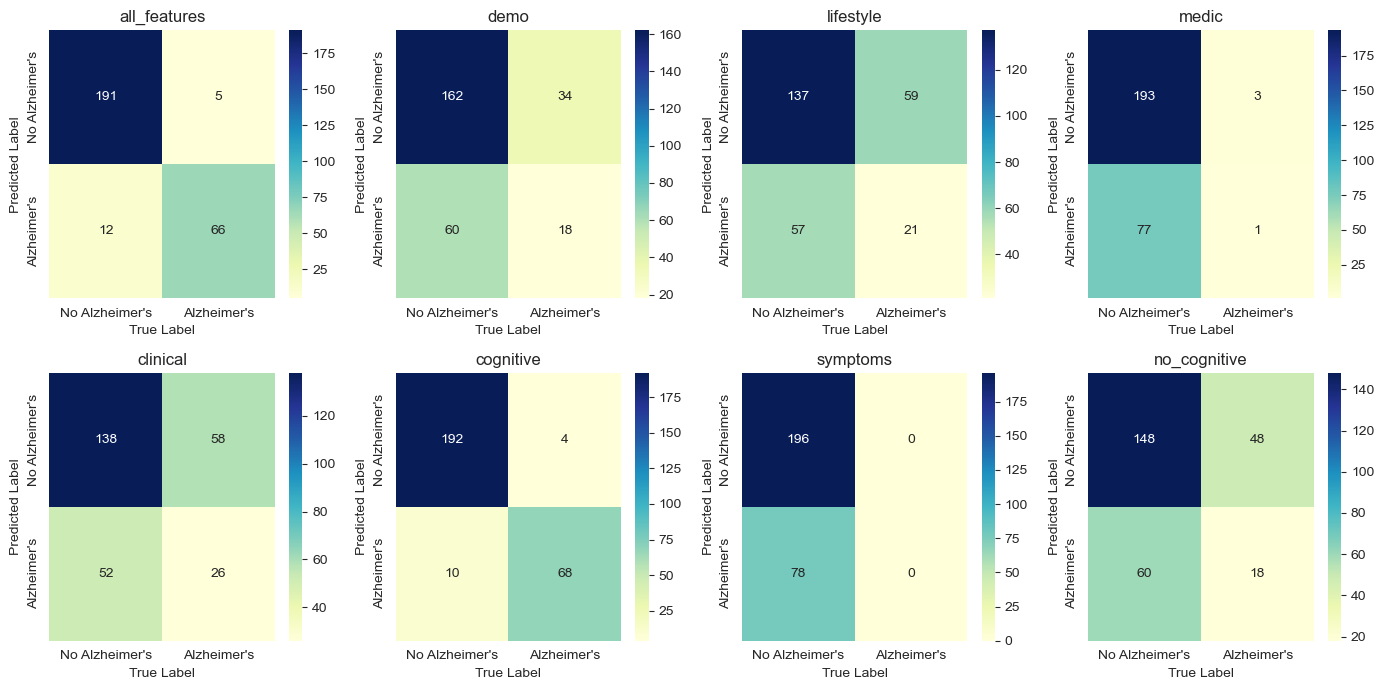

In [13]:
# Define hyperparameter grid
param_grid = {
    'dt__max_depth': [3, 5, 8, 10, 12, None]
}

# Store metrics and confusion matrices
dt_metrics = {}
dt_conf_matrix = {}

# Run classifier across feature subcategories
for key, features in subcategory_dict.items():
    # Define pipeline
    dt_pipe = Pipeline([
        ('scale', StandardScaler()),  # included for consistency
        ('dt', DecisionTreeClassifier(random_state=123))
    ])

    # GridSearchCV
    grid = GridSearchCV(dt_pipe, param_grid, cv=3, scoring='f1', n_jobs=-1)
    grid.fit(df_train[features[:-1]], df_train.Diagnosis)
    best_model = grid.best_estimator_
    best_params = grid.best_params_

    # Predict
    pred = best_model.predict(df_test[features[:-1]])

    # Store metrics
    dt_metrics[key] = [
        accuracy_score(df_test.Diagnosis, pred),
        precision_score(df_test.Diagnosis, pred, zero_division=0),
        recall_score(df_test.Diagnosis, pred, zero_division=0),
        f1_score(df_test.Diagnosis, pred, zero_division=0),
        best_params['dt__max_depth']
    ]

    # Store confusion matrix
    dt_conf_matrix[key] = confusion_matrix(df_test.Diagnosis, pred)

# Display metrics in a dataframe
dt_metrics_df = pd.DataFrame(
    dt_metrics,
    index=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Best Max Depth']
)
display(dt_metrics_df)

# Plot confusion matrices
fig, axes = plt.subplots(2, 4, figsize=(14, 7))
axes = axes.flatten()

for idx, (key, cm) in enumerate(dt_conf_matrix.items()):
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", ax=axes[idx],
                xticklabels=["No Alzheimer's", "Alzheimer's"],
                yticklabels=["No Alzheimer's", "Alzheimer's"])
    axes[idx].set_title(f"{key}")
    axes[idx].set_xlabel("True Label")
    axes[idx].set_ylabel("Predicted Label")

for i in range(len(dt_conf_matrix), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# Gaussian Naǐve Bayes

,all_features,demo,lifestyle,medic,clinical,cognitive,symptoms,no_cognitive
Accuracy,0.846715,0.715328,0.715328,0.711679,0.715328,0.864964,0.715328,0.704380
Precision,0.781250,0.000000,0.000000,0.000000,0.000000,0.847458,0.000000,0.285714
Recall,0.641026,0.000000,0.000000,0.000000,0.000000,0.641026,0.000000,0.025641
F1 Score,0.704225,0.000000,0.000000,0.000000,0.000000,0.729927,0.000000,0.047059


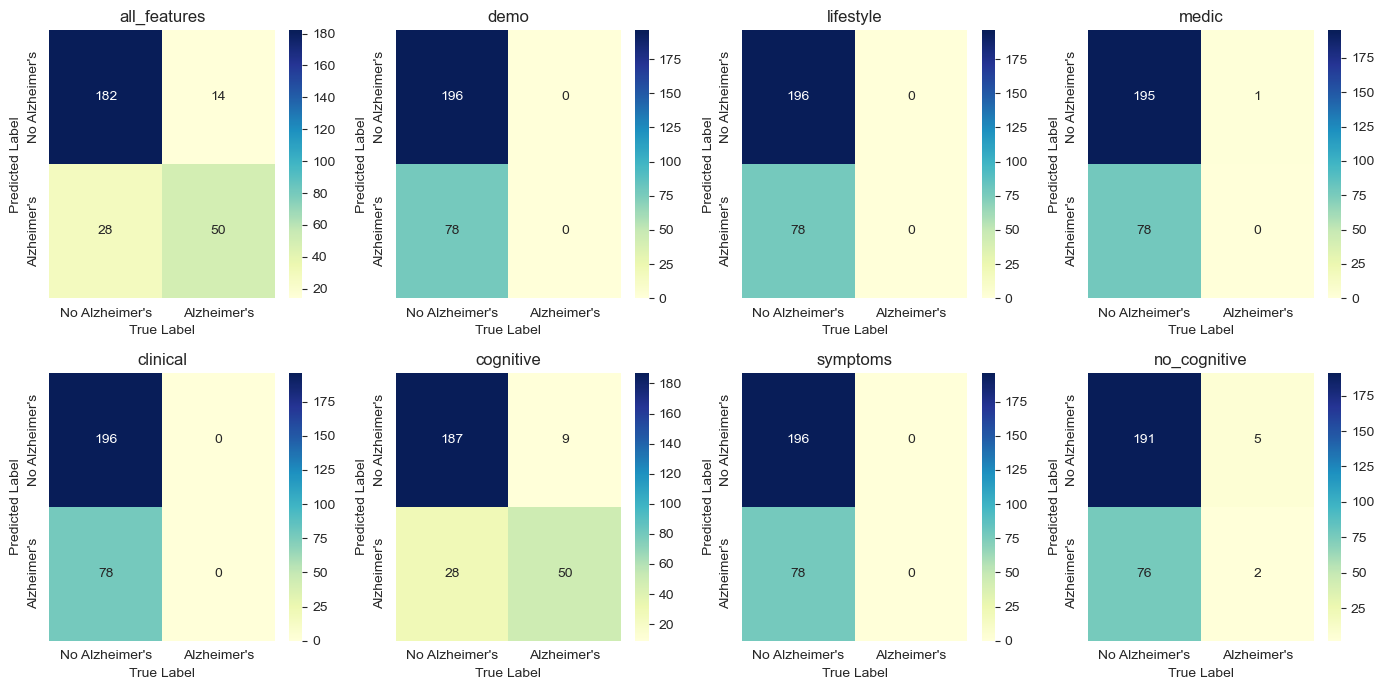

In [15]:
# Pipeline
gnb_pipe = Pipeline([
    ('scale', StandardScaler()), 
    ('gnb', GaussianNB())
])

# Store metrics and confusion matrices
gnb_metrics = {}
gnb_conf_matrix = {}

# Run classifier across feature subcategories
for key, features in subcategory_dict.items():
    gnb_pipe.fit(df_train[features[:-1]], df_train.Diagnosis)
    pred = gnb_pipe.predict(df_test[features[:-1]])

    # Store metrics
    gnb_metrics[key] = [
        accuracy_score(df_test.Diagnosis, pred),
        precision_score(df_test.Diagnosis, pred, zero_division=0),
        recall_score(df_test.Diagnosis, pred, zero_division=0),
        f1_score(df_test.Diagnosis, pred, zero_division=0)
    ]

    # Store confusion matrix
    gnb_conf_matrix[key] = confusion_matrix(df_test.Diagnosis, pred)

# Display metrics in a dataframe
gnb_metrics_df = pd.DataFrame(gnb_metrics, index=['Accuracy', 'Precision', 'Recall', 'F1 Score'])
display(gnb_metrics_df)

# Plot confusion matrices
fig, axes = plt.subplots(2, 4, figsize=(14, 7))
axes = axes.flatten()

for idx, (key, cm) in enumerate(gnb_conf_matrix.items()):
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", ax=axes[idx],
               xticklabels=["No Alzheimer's", "Alzheimer's"],
                yticklabels=["No Alzheimer's", "Alzheimer's"])
    axes[idx].set_title(key)
    axes[idx].set_xlabel("True Label")
    axes[idx].set_ylabel("Predicted Label")

for i in range(len(gnb_conf_matrix), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# Linear Discriminant Analysis (LDA)

,all_features,demo,lifestyle,medic,clinical,cognitive,symptoms,no_cognitive
Accuracy,0.872263,0.715328,0.715328,0.715328,0.715328,0.864964,0.715328,0.715328
Precision,0.802817,0.000000,0.000000,0.000000,0.000000,0.825397,0.000000,0.000000
Recall,0.730769,0.000000,0.000000,0.000000,0.000000,0.666667,0.000000,0.000000
F1 Score,0.765101,0.000000,0.000000,0.000000,0.000000,0.737589,0.000000,0.000000


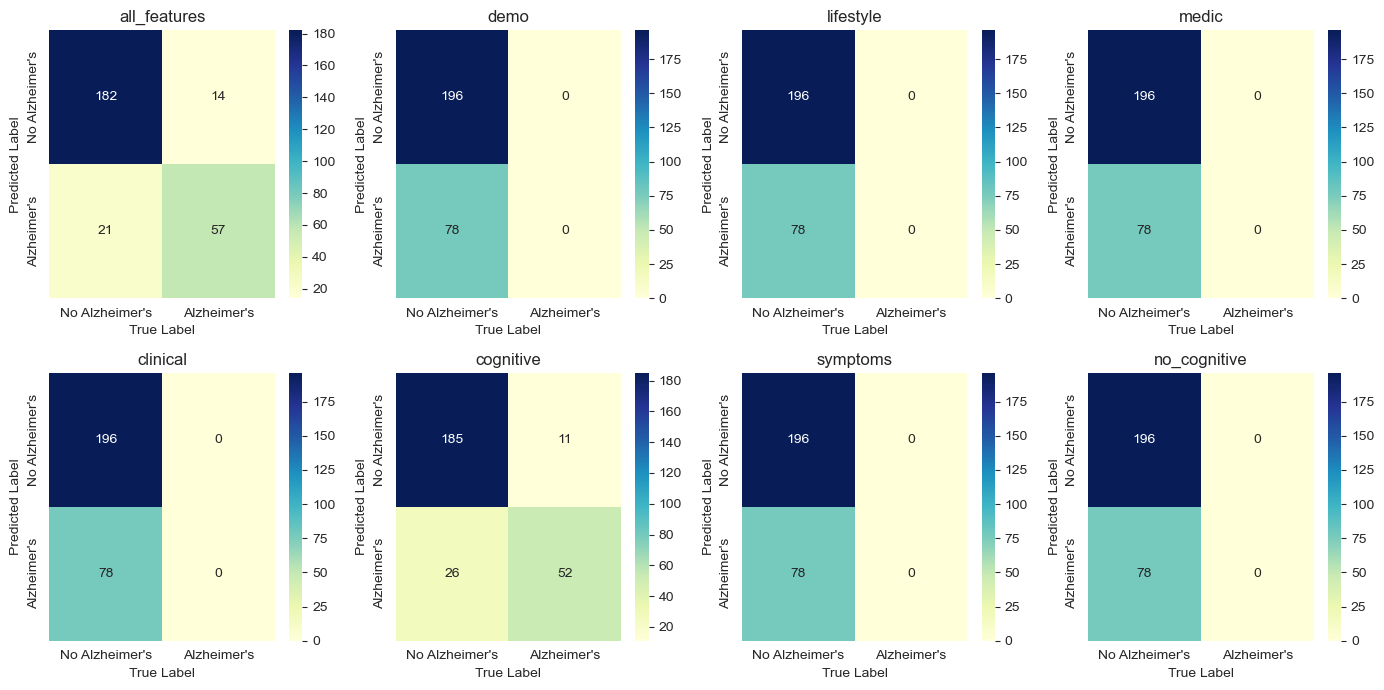

In [17]:
# Pipeline
lda_pipe = Pipeline([
    ('scale', StandardScaler()), 
    ('lda', LinearDiscriminantAnalysis())
])

# Store metrics and confusion matrices
lda_metrics = {}
lda_conf_matrix = {}

# Run classifier across feature subcategories
for key, features in subcategory_dict.items():
    lda_pipe.fit(df_train[features[:-1]], df_train.Diagnosis)
    pred = lda_pipe.predict(df_test[features[:-1]])

    # Store metrics
    lda_metrics[key] = [
        accuracy_score(df_test.Diagnosis, pred),
        precision_score(df_test.Diagnosis, pred, zero_division=0),
        recall_score(df_test.Diagnosis, pred, zero_division=0),
        f1_score(df_test.Diagnosis, pred, zero_division=0)
    ]

    # Store confusion matrix
    lda_conf_matrix[key] = confusion_matrix(df_test.Diagnosis, pred)

# Display metrics in a dataframe
lda_metrics_df = pd.DataFrame(lda_metrics, index=['Accuracy', 'Precision', 'Recall', 'F1 Score'])
display(lda_metrics_df)

# Plot confusion matrices
fig, axes = plt.subplots(2, 4, figsize=(14, 7))
axes = axes.flatten()

for idx, (key, cm) in enumerate(lda_conf_matrix.items()):
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", ax=axes[idx],
               xticklabels=["No Alzheimer's", "Alzheimer's"],
                yticklabels=["No Alzheimer's", "Alzheimer's"])
    axes[idx].set_title(key)
    axes[idx].set_xlabel("True Label")
    axes[idx].set_ylabel("Predicted Label")

for i in range(len(lda_conf_matrix), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# Quadtratic Discriminant Analysis (QDA)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


,all_features,demo,lifestyle,medic,clinical,cognitive,symptoms,no_cognitive
Accuracy,0.766423,0.715328,0.715328,0.700730,0.711679,0.711679,0.715328,0.605839
Precision,0.612903,0.000000,0.000000,0.300000,0.333333,0.400000,0.000000,0.222222
Recall,0.487179,0.000000,0.000000,0.038462,0.012821,0.025641,0.000000,0.153846
F1 Score,0.542857,0.000000,0.000000,0.068182,0.024691,0.048193,0.000000,0.181818


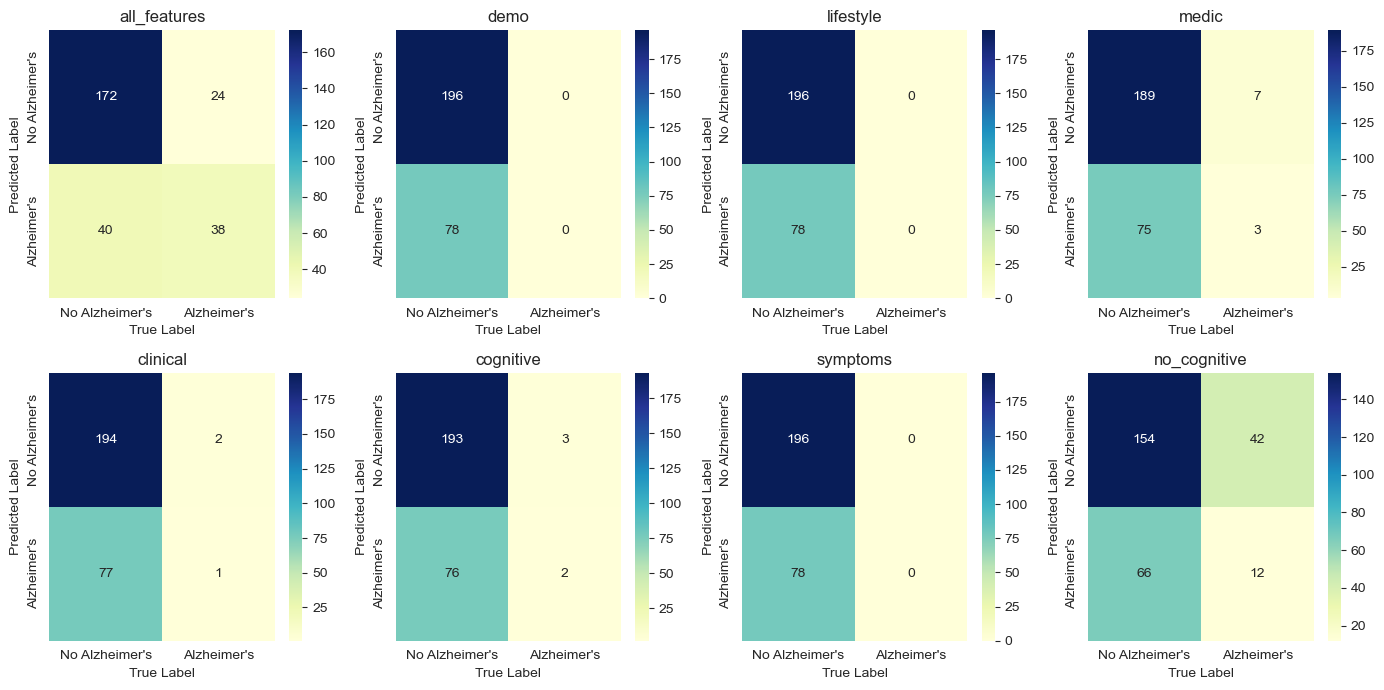

In [26]:
# Pipeline
qda_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('qda', QuadraticDiscriminantAnalysis())
])

# Store metrics and confusion matrices
qda_metrics = {}
qda_conf_matrix = {}

# Run classifier across feature subcategories
for key, features in subcategory_dict.items():
    qda_pipe.fit(df_train[features[:-1]], df_train.Diagnosis)
    pred = qda_pipe.predict(df_test[features[:-1]])

    # Store metrics
    qda_metrics[key] = [
        accuracy_score(df_test.Diagnosis, pred),
        precision_score(df_test.Diagnosis, pred, zero_division=0),
        recall_score(df_test.Diagnosis, pred, zero_division=0),
        f1_score(df_test.Diagnosis, pred, zero_division=0)
    ]

    # Store confusion matrix
    qda_conf_matrix[key] = confusion_matrix(df_test.Diagnosis, pred)

# Display metrics in a dataframe
qda_metrics_df = pd.DataFrame(qda_metrics, index=['Accuracy', 'Precision', 'Recall', 'F1 Score'])
display(qda_metrics_df)

# Plot confusion matrices
fig, axes = plt.subplots(2, 4, figsize=(14, 7))
axes = axes.flatten()

for idx, (key, cm) in enumerate(qda_conf_matrix.items()):
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", ax=axes[idx],
                xticklabels=["No Alzheimer's", "Alzheimer's"],
                yticklabels=["No Alzheimer's", "Alzheimer's"])
    axes[idx].set_title(key)
    axes[idx].set_xlabel("True Label")
    axes[idx].set_ylabel("Predicted Label")

for i in range(len(qda_conf_matrix), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# Support Vector Machines (SVM)

In this section, we explore Support Vector Machines (SVM) using different kernel functions, with the goal of identifying the best-performing model for each feature subcategory. For each kernel, we perform hyperparameter tuning using GridSearchCV to optimize model performance based on F1 score.

We evaluate the following kernel types:

- Polynomial kernel (degrees 1 to 4)
- Radial Basis Function (RBF) kernel
- Sigmoid kernel

Each kernel is tested across various regularization and kernel-specific parameters.

## Polynomial Kernel

,all_features,demo,lifestyle,medic,clinical,cognitive,symptoms,no_cognitive
Accuracy,0.872263,0.715328,0.678832,0.708029,0.697080,0.864964,0.715328,0.514599
Precision,0.802817,0.000000,0.083333,0.250000,0.333333,0.836066,0.000000,0.222222
Recall,0.730769,0.000000,0.012821,0.012821,0.064103,0.653846,0.000000,0.282051
F1 Score,0.765101,0.000000,0.022222,0.024390,0.107527,0.733813,0.000000,0.248588
Best C,100.000000,100.000000,100.000000,100.000000,100.000000,10.000000,100.000000,100.000000
Best Degree,1.000000,1.000000,4.000000,3.000000,4.000000,1.000000,1.000000,2.000000


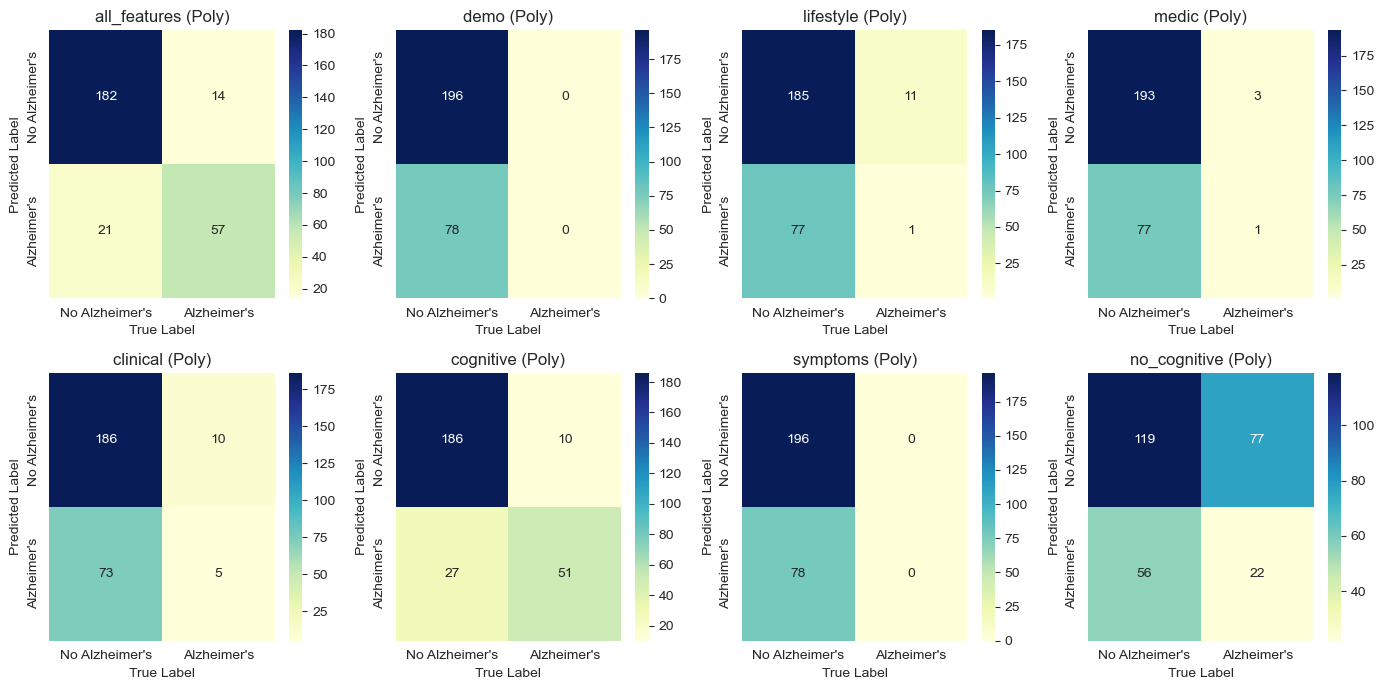

In [28]:
# Define hyperparameter grid
param_grid = {
    'svc__C': [100, 10, 1, 0.1],
    'svc__degree': [1, 2, 3, 4],
    'svc__kernel': ['poly']
}

# Store metrics and confusion matrices
svm_poly_metrics = {}
svm_poly_conf_matrix = {}
svm_poly_best_params = {}

# Run classifier across feature subcategories
for key, features in subcategory_dict.items():
    # Define pipeline
    poly_pipe = Pipeline([
        ('scale', StandardScaler()),
        ('svc', SVC())                           # Note: User may add max_iter parameter here to make it converge faster.
    ])

    # GridSearchCV
    grid = GridSearchCV(poly_pipe, param_grid, cv=3, scoring='f1', n_jobs=-1)
    grid.fit(df_train[features[:-1]], df_train.Diagnosis)
    best_model = grid.best_estimator_
    best_params = grid.best_params_

    # Predict
    pred = best_model.predict(df_test[features[:-1]])

    # Store metrics
    svm_poly_metrics[key] = [
        accuracy_score(df_test.Diagnosis, pred),
        precision_score(df_test.Diagnosis, pred, zero_division=0),
        recall_score(df_test.Diagnosis, pred, zero_division=0),
        f1_score(df_test.Diagnosis, pred, zero_division=0),
        best_params['svc__C'],
        best_params['svc__degree']
    ]

    # Store confusion matrix
    svm_poly_conf_matrix[key] = confusion_matrix(df_test.Diagnosis, pred)

# Display metrics in a dataframe
svm_poly_metrics_df = pd.DataFrame(
    svm_poly_metrics,
    index=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Best C', 'Best Degree']
)
display(svm_poly_metrics_df)

# Plot confusion matrices
fig, axes = plt.subplots(2, 4, figsize=(14, 7))
axes = axes.flatten()

for idx, (key, cm) in enumerate(svm_poly_conf_matrix.items()):
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", ax=axes[idx],
                xticklabels=["No Alzheimer's", "Alzheimer's"],
                yticklabels=["No Alzheimer's", "Alzheimer's"])
    axes[idx].set_title(f"{key} (Poly)")
    axes[idx].set_xlabel("True Label")
    axes[idx].set_ylabel("Predicted Label")

for i in range(len(svm_poly_conf_matrix), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

## Gaussian RBF

,all_features,demo,lifestyle,medic,clinical,cognitive,symptoms,no_cognitive
Accuracy,0.875912,0.715328,0.631387,0.708029,0.645985,0.941606,0.715328,0.551095
Precision,0.823529,0.500000,0.311475,0.250000,0.366197,0.942857,0.000000,0.247191
Recall,0.717949,0.166667,0.243590,0.012821,0.333333,0.846154,0.000000,0.282051
F1 Score,0.767123,0.250000,0.273381,0.024390,0.348993,0.891892,0.000000,0.263473
Best C,100.000000,100.000000,10.000000,100.000000,100.000000,10.000000,100.000000,100.000000
Best Gamma,0.001000,1.000000,1.000000,0.100000,1.000000,1.000000,1.000000,0.010000


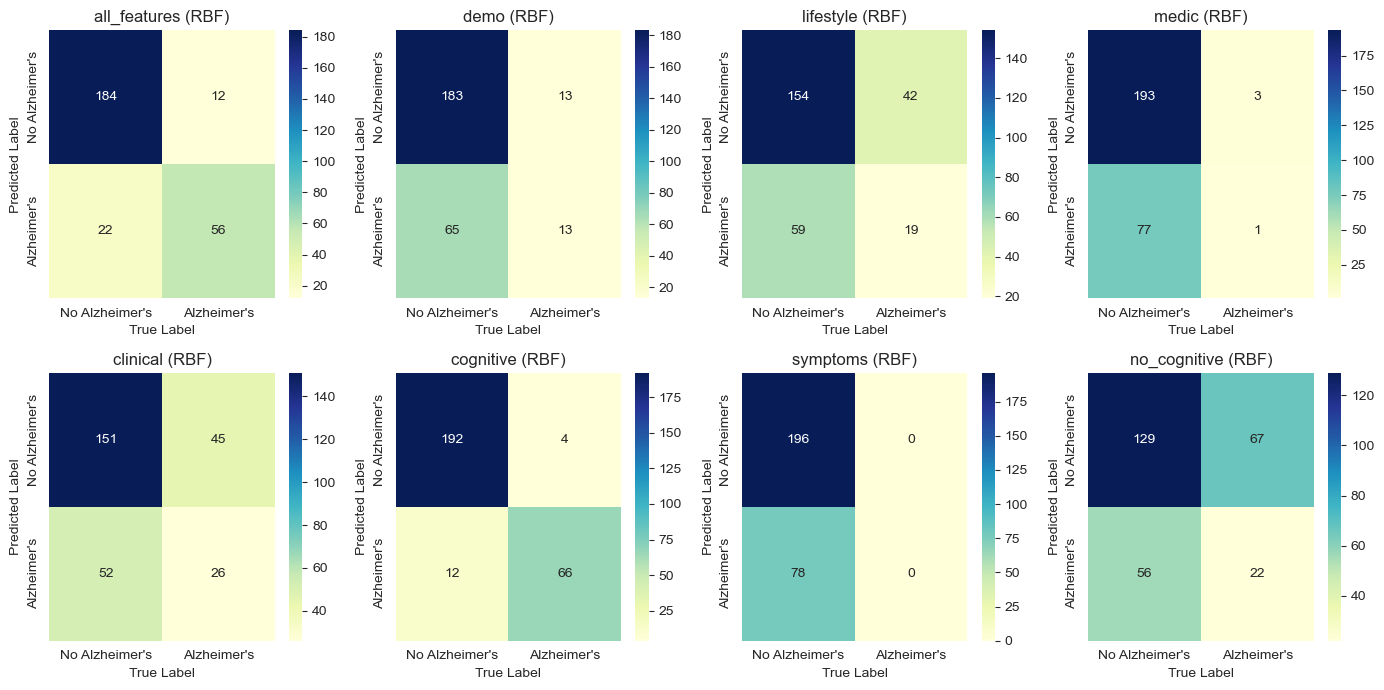

In [30]:
# Define hyperparameter grid
param_grid = {
    'svc__C': [100, 10, 1, 0.1],
    'svc__gamma': [1, 0.1, 0.01, 0.001],
    'svc__kernel': ['rbf']
}

# Store metrics and confusion matrices
svm_rbf_metrics = {}
svm_rbf_conf_matrix = {}

# Run classifier across feature subcategories
for key, features in subcategory_dict.items():
    # Define pipeline
    rbf_pipe = Pipeline([
        ('scale', StandardScaler()),
        ('svc', SVC())                             # Note: User may add max_iter parameter here to make it converge faster.
    ])

    # GridSearchCV
    grid = GridSearchCV(rbf_pipe, param_grid, cv=3, scoring='f1', n_jobs=-1)
    grid.fit(df_train[features[:-1]], df_train.Diagnosis)
    best_model = grid.best_estimator_
    best_params = grid.best_params_

    # Predict
    pred = best_model.predict(df_test[features[:-1]])

    # Store metrics
    svm_rbf_metrics[key] = [
        accuracy_score(df_test.Diagnosis, pred),
        precision_score(df_test.Diagnosis, pred, zero_division=0),
        recall_score(df_test.Diagnosis, pred, zero_division=0),
        f1_score(df_test.Diagnosis, pred, zero_division=0),
        best_params['svc__C'],
        best_params['svc__gamma']
    ]

    # Store confusion matrix
    svm_rbf_conf_matrix[key] = confusion_matrix(df_test.Diagnosis, pred)

# Display metrics in a dataframe
svm_rbf_metrics_df = pd.DataFrame(
    svm_rbf_metrics,
    index=['Accuracy', 'Precision', 'Recall', 'F1 Score','Best C', 'Best Gamma']
)
display(svm_rbf_metrics_df)

# Plot confusion matrices
fig, axes = plt.subplots(2, 4, figsize=(14, 7))
axes = axes.flatten()

for idx, (key, cm) in enumerate(svm_rbf_conf_matrix.items()):
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", ax=axes[idx],
                xticklabels=["No Alzheimer's", "Alzheimer's"],
                yticklabels=["No Alzheimer's", "Alzheimer's"])
    axes[idx].set_title(f"{key} (RBF)")
    axes[idx].set_xlabel("True Label")
    axes[idx].set_ylabel("Predicted Label")

for i in range(len(svm_rbf_conf_matrix), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

## Sigmoid Kernel

,all_features,demo,lifestyle,medic,clinical,cognitive,symptoms,no_cognitive
Accuracy,0.864964,0.605839,0.605839,0.613139,0.572993,0.912409,0.653285,0.591241
Precision,0.797101,0.302632,0.232143,0.258621,0.232877,0.875000,0.206897,0.276316
Recall,0.705128,0.294872,0.166667,0.192308,0.217949,0.807692,0.076923,0.269231
F1 Score,0.748299,0.298701,0.194030,0.220588,0.225166,0.840000,0.112150,0.272727
Best C,10.000000,10.000000,100.000000,0.100000,100.000000,100.000000,100.000000,100.000000
Best Gamma,0.010000,1.000000,1.000000,1.000000,1.000000,0.100000,0.100000,0.100000
Best Coef0,0.000000,-1.000000,1.000000,1.000000,-1.000000,-1.000000,1.000000,-1.000000


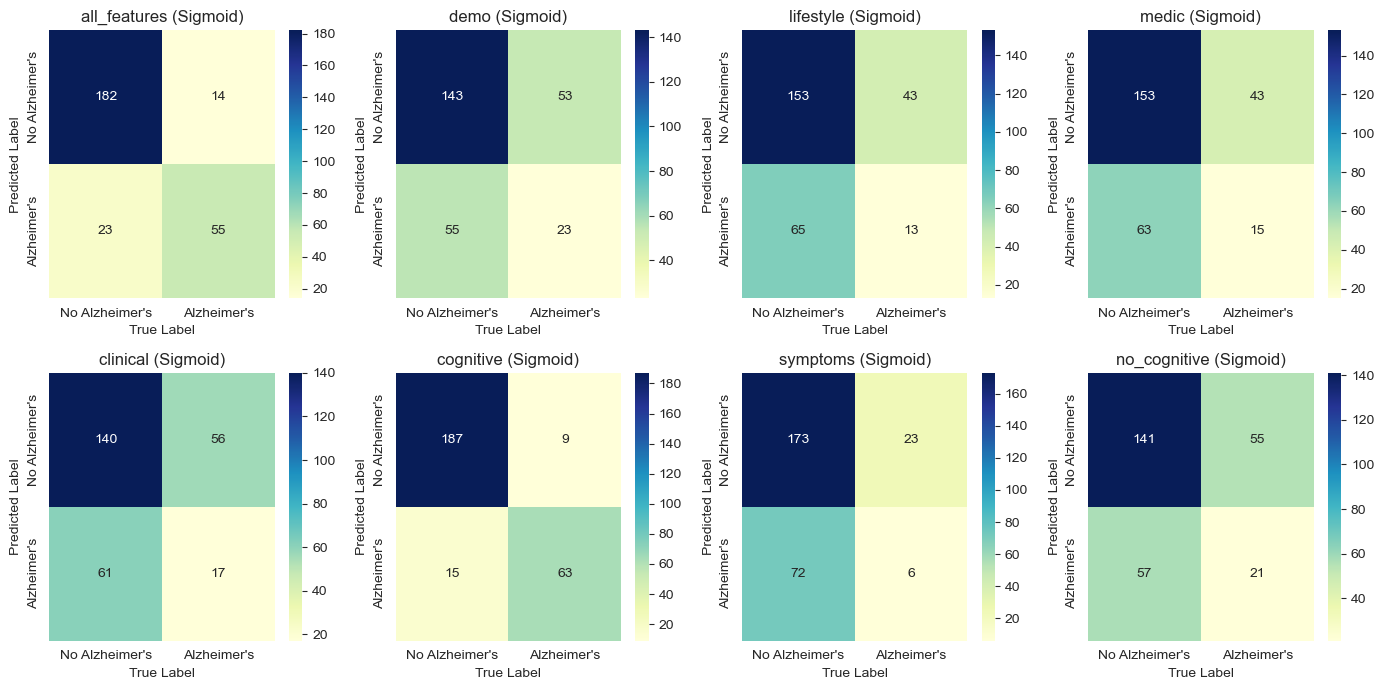

In [32]:
# Define hyperparameter grid
param_grid = {
    'svc__C': [100, 10, 1, 0.1],
    'svc__gamma': [1, 0.1, 0.01, 0.001],
    'svc__coef0': [-1, 0, 1],
    'svc__kernel': ['sigmoid']
}

# Store metrics and confusion matrices
svm_sigmoid_metrics = {}
svm_sigmoid_conf_matrix = {}

# Run classifier across feature subcategories
for key, features in subcategory_dict.items():
    # Define pipeline
    sigmoid_pipe = Pipeline([
        ('scale', StandardScaler()),
        ('svc', SVC())                            # Note: User may add max_iter parameter here to make it converge faster.
    ])

    # GridSearchCV
    grid = GridSearchCV(sigmoid_pipe, param_grid, cv=3, scoring='f1', n_jobs=-1)
    grid.fit(df_train[features[:-1]], df_train.Diagnosis)
    best_model = grid.best_estimator_
    best_params = grid.best_params_

    # Predict
    pred = best_model.predict(df_test[features[:-1]])

    # Store metrics
    svm_sigmoid_metrics[key] = [
        accuracy_score(df_test.Diagnosis, pred),
        precision_score(df_test.Diagnosis, pred, zero_division=0),
        recall_score(df_test.Diagnosis, pred, zero_division=0),
        f1_score(df_test.Diagnosis, pred, zero_division=0),
        best_params['svc__C'],
        best_params['svc__gamma'],
        best_params['svc__coef0']
    ]

    # Store confusion matrix
    svm_sigmoid_conf_matrix[key] = confusion_matrix(df_test.Diagnosis, pred)

# Display metrics in a dataframe
svm_sigmoid_metrics_df = pd.DataFrame(
    svm_sigmoid_metrics,
    index=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Best C', 'Best Gamma', 'Best Coef0']
)
display(svm_sigmoid_metrics_df)

# Plot confusion matrices
fig, axes = plt.subplots(2, 4, figsize=(14, 7))
axes = axes.flatten()

for idx, (key, cm) in enumerate(svm_sigmoid_conf_matrix.items()):
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", ax=axes[idx],
                xticklabels=["No Alzheimer's", "Alzheimer's"],
                yticklabels=["No Alzheimer's", "Alzheimer's"])
    axes[idx].set_title(f"{key} (Sigmoid)")
    axes[idx].set_xlabel("True Label")
    axes[idx].set_ylabel("Predicted Label")

for i in range(len(svm_sigmoid_conf_matrix), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# Stochastic Gradient Descent Classifier

We’ll tune the regularization strength alpha and the penalty parameters using GridSearchCV. User may also tune the loss function, but we use hinge loss here.

,all_features,demo,lifestyle,medic,clinical,cognitive,symptoms,no_cognitive
Accuracy,0.864964,0.715328,0.660584,0.660584,0.635036,0.875912,0.715328,0.620438
Precision,0.815385,0.0,0.325581,0.307692,0.194444,0.854839,0.0,0.275862
Recall,0.679487,0.0,0.179487,0.153846,0.089744,0.679487,0.0,0.205128
F1 Score,0.741259,0.0,0.231405,0.205128,0.122807,0.757143,0.0,0.235294
Best Alpha,0.01,0.0001,0.0001,0.0001,0.0001,0.01,0.0001,0.0001
Best Penalty,l2,elasticnet,l2,l2,l2,l2,l2,l2


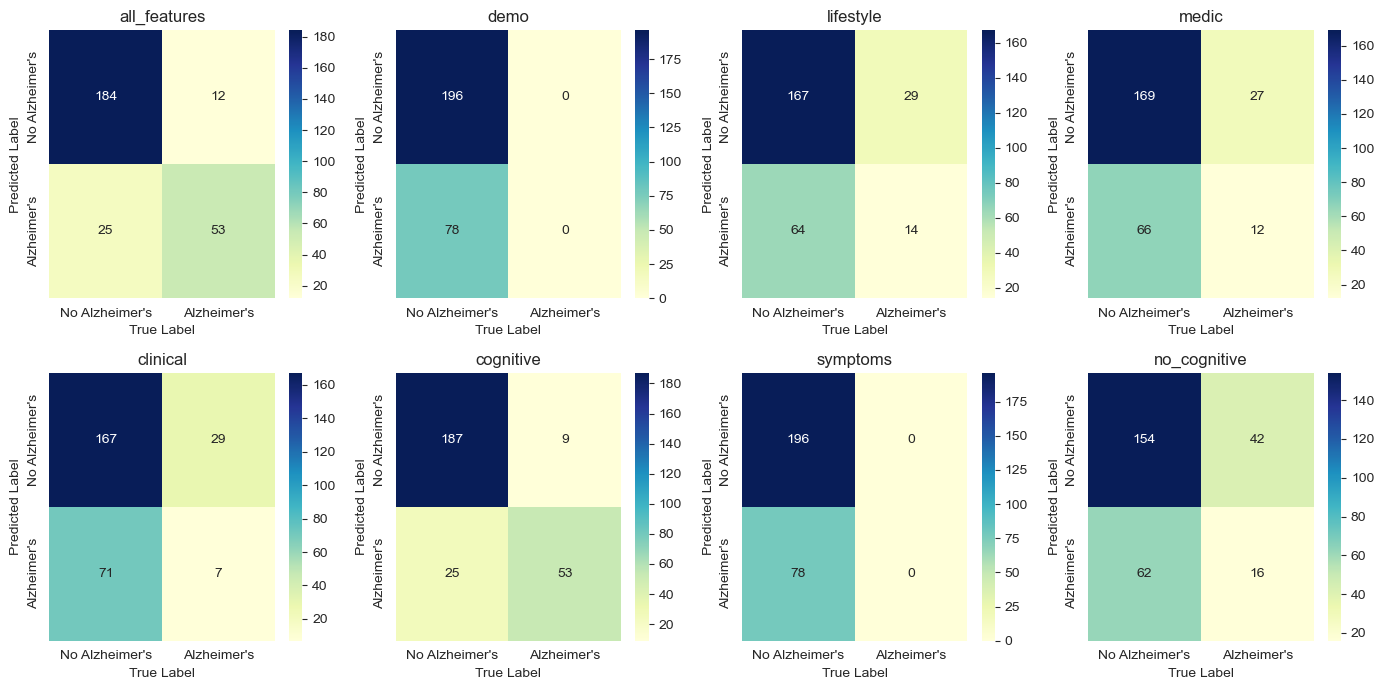

In [34]:
# Define hyperparameter grid
param_grid = {
    'sgd__alpha': [0.0001, 0.001, 0.01],
    'sgd__penalty': ['l2', 'l1', 'elasticnet']
}

# Store metrics and confusion matrices
sgd_metrics = {}
sgd_conf_matrix = {}

# Run classifier across feature subcategories
for key, features in subcategory_dict.items():
    # Define pipeline
    sgd_pipe = Pipeline([
        ('scale', StandardScaler()),
        ('sgd', SGDClassifier(loss='hinge', random_state=123))
    ])

    # GridSearchCV
    grid = GridSearchCV(sgd_pipe, param_grid, cv=3, scoring='f1', n_jobs=-1)
    grid.fit(df_train[features[:-1]], df_train.Diagnosis)
    best_model = grid.best_estimator_
    best_params = grid.best_params_

    # Predict
    pred = best_model.predict(df_test[features[:-1]])

    # Store metrics
    sgd_metrics[key] = [
        accuracy_score(df_test.Diagnosis, pred),
        precision_score(df_test.Diagnosis, pred, zero_division=0),
        recall_score(df_test.Diagnosis, pred, zero_division=0),
        f1_score(df_test.Diagnosis, pred, zero_division=0),
        best_params['sgd__alpha'],
        best_params['sgd__penalty']
    ]

    # Store confusion matrix
    sgd_conf_matrix[key] = confusion_matrix(df_test.Diagnosis, pred)

# Display metrics in a dataframe
sgd_metrics_df = pd.DataFrame(
    sgd_metrics,
    index=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Best Alpha', 'Best Penalty']
)
display(sgd_metrics_df)

# Plot confusion matrices
fig, axes = plt.subplots(2, 4, figsize=(14, 7))
axes = axes.flatten()

for idx, (key, cm) in enumerate(sgd_conf_matrix.items()):
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", ax=axes[idx],
                xticklabels=["No Alzheimer's", "Alzheimer's"],
                yticklabels=["No Alzheimer's", "Alzheimer's"])
    axes[idx].set_title(f"{key}")
    axes[idx].set_xlabel("True Label")
    axes[idx].set_ylabel("Predicted Label")

for i in range(len(sgd_conf_matrix), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# Random Forest

We’ll tune the max_depth parameter using GridSearchCV.

,all_features,demo,lifestyle,medic,clinical,cognitive,symptoms,no_cognitive
Accuracy,0.930657,0.653285,0.715328,0.708029,0.700730,0.948905,0.715328,0.711679
Precision,0.968254,0.339623,0.500000,0.250000,0.300000,0.957143,0.000000,0.333333
Recall,0.782051,0.230769,0.076923,0.012821,0.038462,0.858974,0.000000,0.012821
F1 Score,0.865248,0.274809,0.133333,0.024390,0.068182,0.905405,0.000000,0.024691
Best Max Depth,NaN,NaN,NaN,8.000000,NaN,8.000000,3.000000,NaN


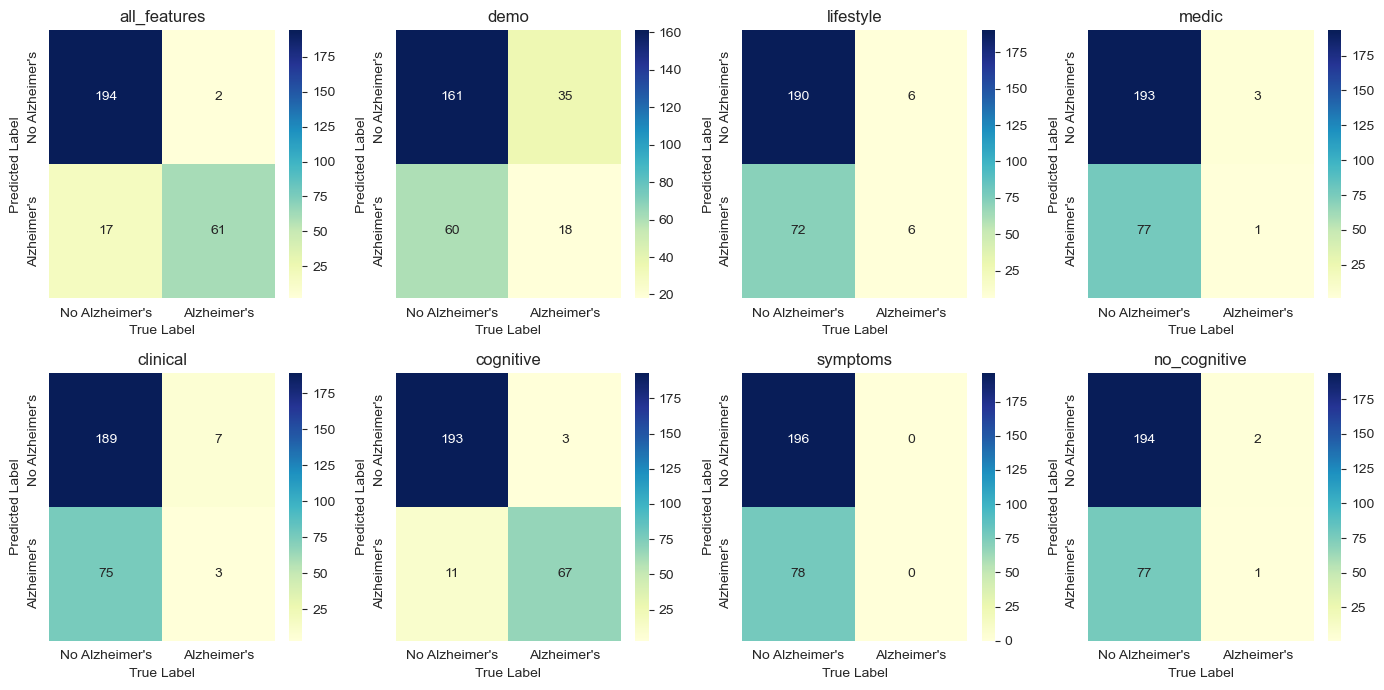

In [36]:
# Define hyperparameter grid
param_grid = {
    'rf__max_depth': [3, 5, 8, 10, 12, None]
}

# Store metrics and confusion matrices
rf_metrics = {}
rf_conf_matrix = {}

# Run classifier across feature subcategories
for key, features in subcategory_dict.items():
    # Define pipeline
    rf_pipe = Pipeline([
        ('scale', StandardScaler()),  # included for consistency
        ('rf', RandomForestClassifier(random_state=123))
    ])

    # GridSearchCV
    grid = GridSearchCV(rf_pipe, param_grid, cv=3, scoring='f1', n_jobs=-1)
    grid.fit(df_train[features[:-1]], df_train.Diagnosis)
    best_model = grid.best_estimator_
    best_params = grid.best_params_

    # Predict
    pred = best_model.predict(df_test[features[:-1]])

    # Store metrics
    rf_metrics[key] = [
        accuracy_score(df_test.Diagnosis, pred),
        precision_score(df_test.Diagnosis, pred, zero_division=0),
        recall_score(df_test.Diagnosis, pred, zero_division=0),
        f1_score(df_test.Diagnosis, pred, zero_division=0),
        best_params['rf__max_depth']
    ]

    # Store confusion matrix
    rf_conf_matrix[key] = confusion_matrix(df_test.Diagnosis, pred)

# Display metrics in a dataframe
rf_metrics_df = pd.DataFrame(
    rf_metrics,
    index=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Best Max Depth']
)
display(rf_metrics_df)

# Plot confusion matrices
fig, axes = plt.subplots(2, 4, figsize=(14, 7))
axes = axes.flatten()

for idx, (key, cm) in enumerate(rf_conf_matrix.items()):
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", ax=axes[idx],
                xticklabels=["No Alzheimer's", "Alzheimer's"],
                yticklabels=["No Alzheimer's", "Alzheimer's"])
    axes[idx].set_title(f"{key}")
    axes[idx].set_xlabel("True Label")
    axes[idx].set_ylabel("Predicted Label")

for i in range(len(rf_conf_matrix), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# Gradient Boosting Classifier (GBC)

We use GridSearchCV to find the best parameters max_depth and learning_rate.

,all_features,demo,lifestyle,medic,clinical,cognitive,symptoms,no_cognitive
Accuracy,0.948905,0.624088,0.624088,0.708029,0.638686,0.941606,0.715328,0.635036
Precision,0.910256,0.307692,0.264151,0.250000,0.301887,0.930556,0.000000,0.288462
Recall,0.910256,0.256410,0.179487,0.012821,0.205128,0.858974,0.000000,0.192308
F1 Score,0.910256,0.279720,0.213740,0.024390,0.244275,0.893333,0.000000,0.230769
Best Learning Rate,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.010000,0.900000
Best Max Depth,3.000000,8.000000,3.000000,8.000000,3.000000,8.000000,3.000000,3.000000


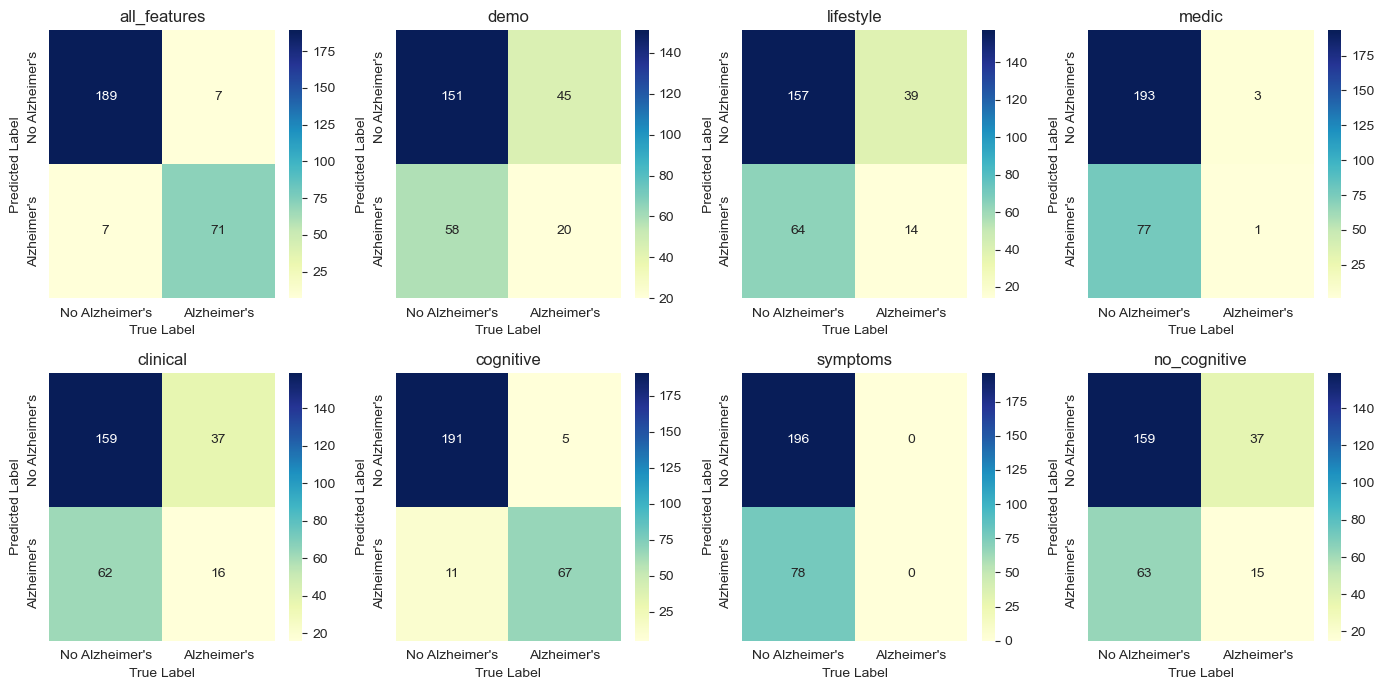

In [52]:
# Warning: This cell takes long to run!

# Define hyperparameter grid
param_grid = {
    'gb__learning_rate': [0.01, 0.5, 0.9],     # Note: User may reduce the number of parameters to get faster convergence.
    'gb__max_depth': [3, 8, 10]
}

# Store metrics and confusion matrices
gb_metrics = {}
gb_conf_matrix = {}

# Run classifier across feature subcategories
for key, features in subcategory_dict.items():
    # Define pipeline
    gb_pipe = Pipeline([
        ('scale', StandardScaler()),  
        ('gb', GradientBoostingClassifier(random_state=123))
    ])

    # GridSearchCV
    grid = GridSearchCV(gb_pipe, param_grid, cv=3, scoring='f1', n_jobs=-1)
    grid.fit(df_train[features[:-1]], df_train.Diagnosis)
    best_model = grid.best_estimator_
    best_params = grid.best_params_

    # Predict
    pred = best_model.predict(df_test[features[:-1]])

    # Store metrics
    gb_metrics[key] = [
        accuracy_score(df_test.Diagnosis, pred),
        precision_score(df_test.Diagnosis, pred, zero_division=0),
        recall_score(df_test.Diagnosis, pred, zero_division=0),
        f1_score(df_test.Diagnosis, pred, zero_division=0),
        best_params['gb__learning_rate'],
        best_params['gb__max_depth']
    ]

    # Store confusion matrix
    gb_conf_matrix[key] = confusion_matrix(df_test.Diagnosis, pred)

# Display metrics in a dataframe
gb_metrics_df = pd.DataFrame(
    gb_metrics,
    index=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Best Learning Rate', 'Best Max Depth']
)
display(gb_metrics_df)

# Plot confusion matrices
fig, axes = plt.subplots(2, 4, figsize=(14, 7))
axes = axes.flatten()

for idx, (key, cm) in enumerate(gb_conf_matrix.items()):
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", ax=axes[idx],
                xticklabels=["No Alzheimer's", "Alzheimer's"],
                yticklabels=["No Alzheimer's", "Alzheimer's"])
    axes[idx].set_title(f"{key}")
    axes[idx].set_xlabel("True Label")
    axes[idx].set_ylabel("Predicted Label")

for i in range(len(gb_conf_matrix), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# Adaptive Boosting (AdaBoost)

We use Decision Tree classifier as the base estimator and try to optimize the learning_rate and the base estimator max_depth.

,all_features,demo,lifestyle,medic,clinical,cognitive,symptoms,no_cognitive
Accuracy,0.948905,0.675182,0.627737,0.708029,0.656934,0.941606,0.715328,0.664234
Precision,0.957143,0.372093,0.285714,0.250000,0.250000,0.955882,0.000000,0.315789
Recall,0.858974,0.205128,0.205128,0.012821,0.102564,0.833333,0.000000,0.153846
F1 Score,0.905405,0.264463,0.238806,0.024390,0.145455,0.890411,0.000000,0.206897
Best Learning Rate,0.500000,1.000000,1.000000,1.000000,1.000000,0.100000,0.100000,1.000000
Best Max Depth,3.000000,5.000000,5.000000,5.000000,3.000000,5.000000,5.000000,3.000000


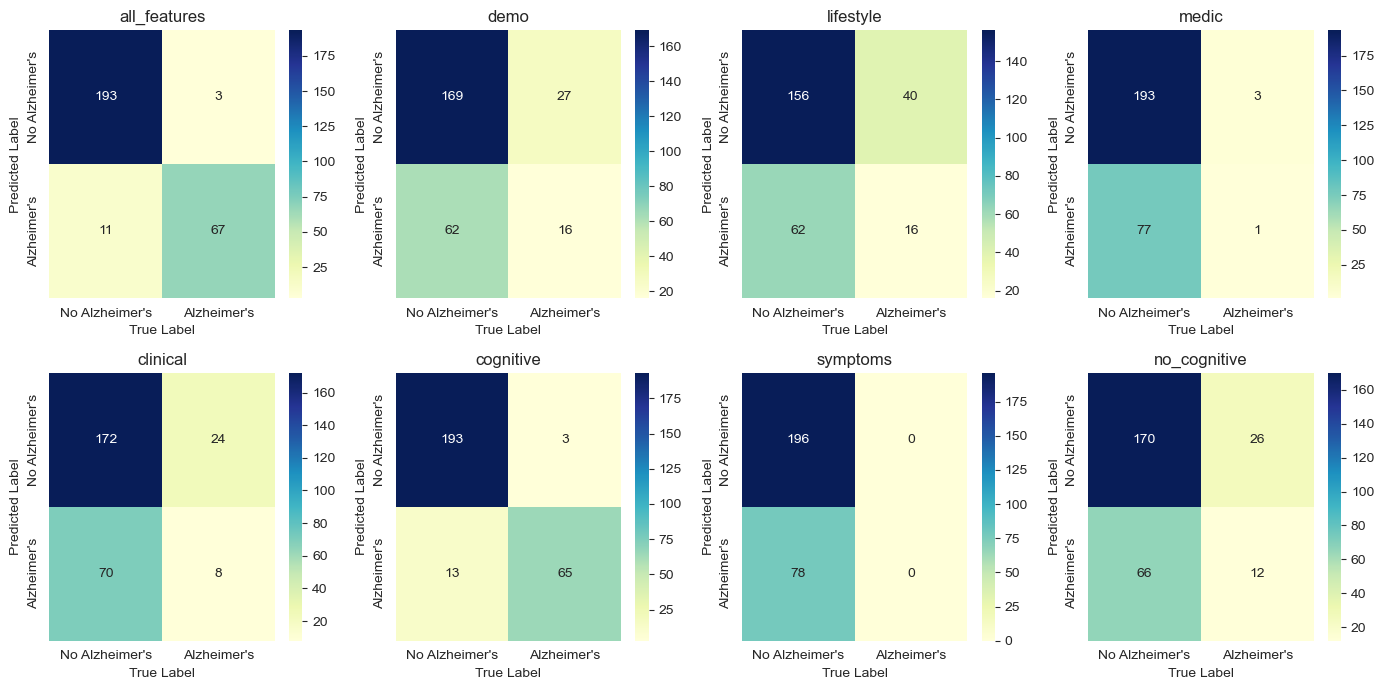

In [44]:
# Warning: This cell takes long to run!

# Define hyperparameter grid
param_grid = {
    'ab__learning_rate': [0.1, 0.5, 1.0],   
    'ab__estimator__max_depth': [2, 3, 5]
}

# Store metrics and confusion matrices
ab_metrics = {}
ab_conf_matrix = {}

# Run classifier across feature subcategories
for key, features in subcategory_dict.items():
    # Define pipeline with custom base estimator
    ab_pipe = Pipeline([
        ('scale', StandardScaler()),  
        ('ab', AdaBoostClassifier(
            estimator=DecisionTreeClassifier(),
            algorithm='SAMME',
            random_state=123
        ))
    ])

    # GridSearchCV
    grid = GridSearchCV(ab_pipe, param_grid, cv=3, scoring='f1', n_jobs=-1)
    grid.fit(df_train[features[:-1]], df_train.Diagnosis)
    best_model = grid.best_estimator_
    best_params = grid.best_params_

    # Predict
    pred = best_model.predict(df_test[features[:-1]])

    # Store metrics
    ab_metrics[key] = [
        accuracy_score(df_test.Diagnosis, pred),
        precision_score(df_test.Diagnosis, pred, zero_division=0),
        recall_score(df_test.Diagnosis, pred, zero_division=0),
        f1_score(df_test.Diagnosis, pred, zero_division=0),
        best_params['ab__learning_rate'],
        best_params['ab__estimator__max_depth']
    ]

    # Store confusion matrix
    ab_conf_matrix[key] = confusion_matrix(df_test.Diagnosis, pred)

# Display metrics in a dataframe
ab_metrics_df = pd.DataFrame(
    ab_metrics,
    index=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Best Learning Rate', 'Best Max Depth']
)
display(ab_metrics_df)

# Plot confusion matrices
fig, axes = plt.subplots(2, 4, figsize=(14, 7))
axes = axes.flatten()

for idx, (key, cm) in enumerate(ab_conf_matrix.items()):
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", ax=axes[idx],
                xticklabels=["No Alzheimer's", "Alzheimer's"],
                yticklabels=["No Alzheimer's", "Alzheimer's"])
    axes[idx].set_title(f"{key}")
    axes[idx].set_xlabel("True Label")
    axes[idx].set_ylabel("Predicted Label")

for i in range(len(ab_conf_matrix), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# Extreme Gradient Boosting (XGBoost)

,all_features,demo,lifestyle,medic,clinical,cognitive,symptoms,no_cognitive
Accuracy,0.956204,0.642336,0.653285,0.708029,0.609489,0.952555,0.715328,0.627737
Precision,0.971429,0.321429,0.333333,0.250000,0.262295,0.957746,0.000000,0.269231
Recall,0.871795,0.230769,0.217949,0.012821,0.205128,0.871795,0.000000,0.179487
F1 Score,0.918919,0.268657,0.263566,0.024390,0.230216,0.912752,0.000000,0.215385
Best Learning Rate,0.100000,0.900000,0.900000,0.900000,0.900000,0.100000,0.010000,0.900000
Best Max Depth,5.000000,5.000000,5.000000,7.000000,3.000000,3.000000,3.000000,3.000000


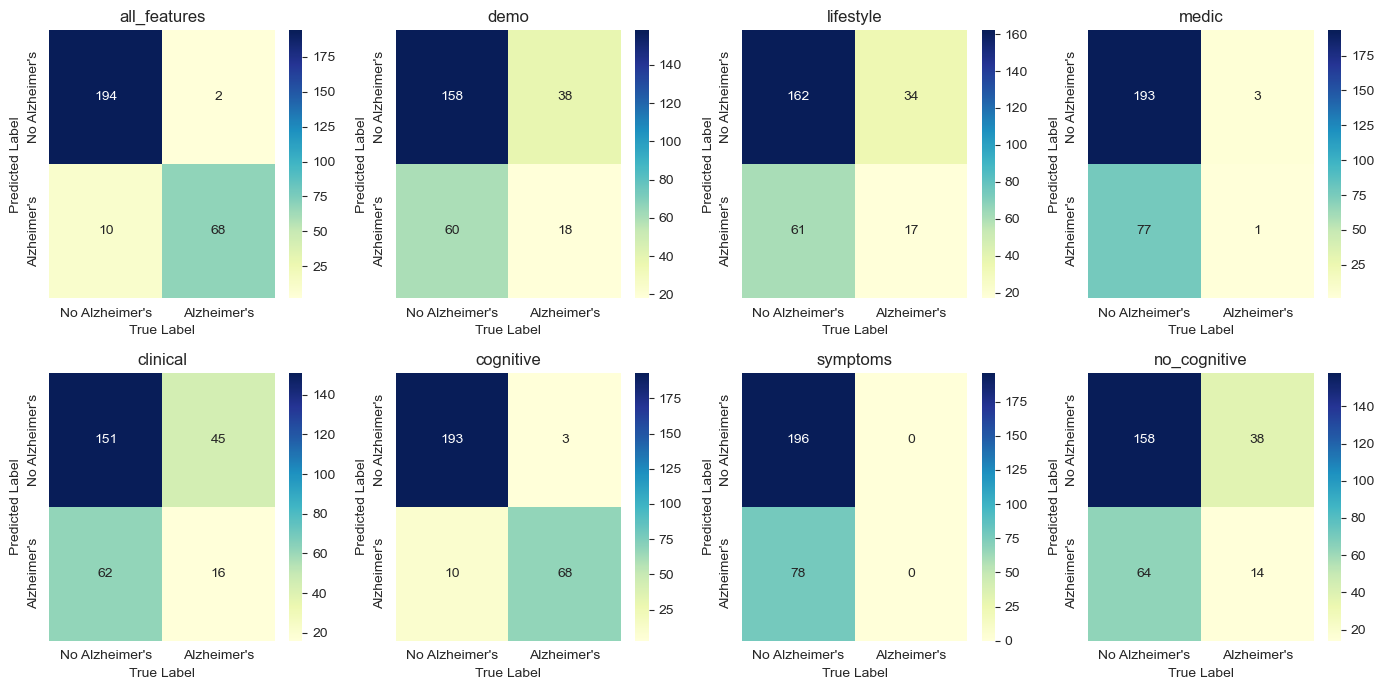

In [46]:
# Warning: This cell takes long to run!

# Define hyperparameter grid
param_grid = {
    'xgb__learning_rate': [0.01, 0.05, 0.1, 0.5, 0.9],      # Note: User may reduce the number of parameters to get faster convergence.
    'xgb__max_depth': [3, 5, 7]
}

# Store metrics and confusion matrices
xgb_metrics = {}
xgb_conf_matrix = {}

# Run classifier across feature subcategories
for key, features in subcategory_dict.items():
    # Define pipeline
    xgb_pipe = Pipeline([
        ('scale', StandardScaler()),  
        ('xgb', XGBClassifier(random_state=123))
    ])

    # GridSearchCV
    grid = GridSearchCV(xgb_pipe, param_grid, cv=3, scoring='f1', n_jobs=-1)
    grid.fit(df_train[features[:-1]], df_train.Diagnosis)
    best_model = grid.best_estimator_
    best_params = grid.best_params_

    # Predict
    pred = best_model.predict(df_test[features[:-1]])

    # Store metrics
    xgb_metrics[key] = [
        accuracy_score(df_test.Diagnosis, pred),
        precision_score(df_test.Diagnosis, pred, zero_division=0),
        recall_score(df_test.Diagnosis, pred, zero_division=0),
        f1_score(df_test.Diagnosis, pred, zero_division=0),
        best_params['xgb__learning_rate'],
        best_params['xgb__max_depth']
    ]

    # Store confusion matrix
    xgb_conf_matrix[key] = confusion_matrix(df_test.Diagnosis, pred)

# Display metrics in a dataframe
xgb_metrics_df = pd.DataFrame(
    xgb_metrics,
    index=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Best Learning Rate', 'Best Max Depth']
)
display(xgb_metrics_df)

# Plot confusion matrices
fig, axes = plt.subplots(2, 4, figsize=(14, 7))
axes = axes.flatten()

for idx, (key, cm) in enumerate(xgb_conf_matrix.items()):
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", ax=axes[idx],
                xticklabels=["No Alzheimer's", "Alzheimer's"],
                yticklabels=["No Alzheimer's", "Alzheimer's"])
    axes[idx].set_title(f"{key}")
    axes[idx].set_xlabel("True Label")
    axes[idx].set_ylabel("Predicted Label")

for i in range(len(xgb_conf_matrix), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# Summary of explored models for patients with no memory complaints

In [54]:
summary_df = pd.DataFrame({
    'Logistic Regression': logreg_metrics_df['all_features'].loc[['Accuracy', 'F1 Score']],
    'KNN': knn_metrics_df['all_features'].loc[['Accuracy', 'F1 Score']],
    'Decision Trees': dt_metrics_df['all_features'].loc[['Accuracy', 'F1 Score']],
    'Gaussian Naǐve Bayes': gnb_metrics_df['all_features'].loc[['Accuracy', 'F1 Score']],
    'LDA': lda_metrics_df['all_features'].loc[['Accuracy', 'F1 Score']],
    'QDA': qda_metrics_df['all_features'].loc[['Accuracy', 'F1 Score']],
    'SVM': svm_poly_metrics_df['all_features'].loc[['Accuracy', 'F1 Score']],
    'Stochastic Gradient Descent': sgd_metrics_df['all_features'].loc[['Accuracy', 'F1 Score']],
    'Random Forest': rf_metrics_df['all_features'].loc[['Accuracy', 'F1 Score']],
    'Gradient Boosting': gb_metrics_df['all_features'].loc[['Accuracy', 'F1 Score']],
    'AdaBoost': ab_metrics_df['all_features'].loc[['Accuracy', 'F1 Score']],
    'XGBoost': xgb_metrics_df['all_features'].loc[['Accuracy', 'F1 Score']]
}).T

summary_df.columns = ['Accuracy', 'F1 Score']
display(summary_df.sort_values(by='Accuracy', ascending=False).round(3))

,Accuracy,F1 Score
XGBoost,0.956204,0.918919
Gradient Boosting,0.948905,0.910256
AdaBoost,0.948905,0.905405
Decision Trees,0.937956,0.885906
Random Forest,0.930657,0.865248
Logistic Regression,0.879562,0.77551
LDA,0.872263,0.765101
SVM,0.872263,0.765101
Stochastic Gradient Descent,0.864964,0.741259
Gaussian Naǐve Bayes,0.846715,0.704225


**Conclusion:** Upon initial model exploration, our best performing model for the sub-dataset of patients having memory complaints is **XGBoost**.